In [ ]:
# [model card] stage: Ignore

# Install necessary pip packages
import sys
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install ipympl
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib

# Enable the ipympl backend
%matplotlib widget

# Import packages for data visualization and model
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

In [ ]:
# [model card] stage: Plotting
def visualizeY(data):
    """ Plots the distribution of targets in input data.

    Parameters
    ----------
    data : numpy.ndarray
    """
    yValues = data[:,len(data[0])-1]

    counts = np.unique(yValues, return_counts=True)[1]
    plotLabels = ["<=50K", ">50K"]
    plotData = [counts[0], counts[1]]
    fig = plt.figure()
    bars = plt.bar(plotLabels, plotData, color ='blue', width=0.2,data='scalar')
    plt.xlabel("Income")
    plt.title("Distribution of Y Values")
    # Access the bar attributes to place the text in the appropriate location
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x(), yval + .005, yval)
    plt.show()

In [ ]:
# [model card] stage: Plotting
def visualizeX(data):
    """ Plots the distribution of the targets for each feature in the input data.
    Data must have 14 features.

    Parameters
    ----------
    data : numpy.ndarray
    """

    fig, axs = plt.subplots(7,2, figsize=(21, 12), facecolor='w', edgecolor='k')
    fig.tight_layout(pad=3.0)
    
    # Separate the targets based on the label 
    y1 = data[data[:,len(data[0])-1] == "<=50K",:]
    y0 = data[data[:,len(data[0])-1] == ">50K",:]
    xfeature = 0
    labels = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status","occupation","relationship", "race", "sex", "capital-gain","capital-loss","hours-per-week" ,"native-country"]
    for x, ax in enumerate(axs.ravel()):
      currentFeature = data[:,xfeature]
      ax.hist([y0[:,xfeature],y1[:,xfeature] ],bins=60, log=True, label=['>50K', '<=50K'])
      ax.axes.xaxis.set_visible(False)
      ax.legend(loc='upper right')  
      ax.set_ylabel("Frequency")
      ax.set_title(labels[xfeature])
      xfeature += 1 

In [117]:
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,f1_score
from sklearn.feature_selection import SelectFromModel

class Classifier:
    """ Functions to train and use a binary classifier with targets >50K and <=50K. 
        For training, all features described in the 1994 Adult Census dataset must be present in the file provided, and their order must not change. 
    """
    
    def __init__(self):
        self.encoders = []      # stores the encoders so that all inputs to the model are encoded the same way
        self.clf = None         # stores the trained model for use in future predictions
        self.features = []
    
    # [model card] stage: Preprocessing
    def getData(self, filename):
        """Retrieve the data downloaded from the UCI Machine Learning Repository.
        Seperate the data into an array X of features and an array Y of targets.
        
        Parameters
        ----------
        filename : str

        Returns
        -------
        X : numpy.ndarray
        Y : numpy.ndarray
        """
        
        data = np.loadtxt(open(filename, "r"),dtype='str', delimiter=", ")
        data = self.preprocess(data)
        X = data[:,:-1]
        Y = data[:,len(data[0])-1]
        return X,Y
    
    # [model card] stage: Preprocessing
    def preprocess(self, data):
        """ Remove any rows with remaining missing values.
        
        Parameters
        ----------
        data : numpy.ndarray

        Returns
        -------
        data : numpy.ndarray
        """

        # Remove any rows with missing values
        data = data[ ~np.any(data == ' ?', axis=1),:]
        return data
    
    
    # [model card] stage: Preprocessing
    def encode(self, X, y):
        """ Convert targets from category labels to binary for use in the model.
        Since the scikit-learn classification model that we are using takes continuous numeric features, 
        we must convert categorical features to their equivalent one-hot encoding.
        A y value of 1 corresponds to an income of <=50K, and a value of 0 corresponds to an income of >50K.
        
        Also converts features to appropriate format for the model, and saves the encoders for use on future model inputs.
        Since the scikit-learn classification model that we are using takes continuous numeric features, 
        we must convert categorical features to their equivalent one-hot encoding.
        This method should only be used when the input features X contain examples of every possible feature category in the dataset. 
        If some categories are not represented in X, the encoding will not represent the full feature space of the dataset, thus the resulting encoding cannot be used for new training examples.
        We also perform feature selection at this step. 
        
        Parameters
        ----------
        X : numpy.ndarray

        Returns
        -------
        oneHotX,yEncoded : numpy.ndarray,numpy.ndarray
        """

        # A Y value of 1 means the person makes less than 50k, and a value of 0 means they make over 50k
        yEncoded = np.where(Y == "<=50K", 1, 0)
        
        features = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status","occupation","relationship", "race", "sex", "capital_gain","capital_loss","hours_per_week" ,"native_country"]
        
        encoders = []
        oneHotX = []
        encodedFeatures = []
        i=0
        for column in X.T:
            column = column.reshape(-1, 1)
            try:
                column.astype(float)
            except ValueError:
                enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
                enc = enc.fit(column)
                column  = enc.transform(column).toarray()
                encoders = np.append(encoders, enc)
            if len(oneHotX) == 0:
                oneHotX = column
            else:
                oneHotX = np.concatenate((column,oneHotX),axis=1)
            for j in range(0,len(column[0])):
                encodedFeatures.append(features[i])
            i += 1
        self.encoders = encoders
        
        # Make a tree for feature selection
        self.fitEncoded(oneHotX,yEncoded)
        # Select features
        newEnc = SelectFromModel(self.clf, prefit=True, threshold=-np.inf, max_features=15)
        oneHotX = newEnc.transform(oneHotX)
        newFeatures = np.unique(newEnc.get_feature_names_out(encodedFeatures))
        self.features = newFeatures
        
        
        oneHotX = []
        encoders = []
        # Fit to selected features
        i=0
        for column in X.T:
            featureName = features[i]
            if featureName in self.features:
                column = column.reshape(-1, 1)
                try:
                    column.astype(float)
                except ValueError:
                    enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
                    enc = enc.fit(column)
                    column  = enc.transform(column).toarray()
                    encoders = np.append(encoders, enc)
                if len(oneHotX) == 0:
                    oneHotX = column
                else:
                    oneHotX = np.concatenate((column,oneHotX),axis=1)
            i += 1
        self.encoders = encoders
        
        return oneHotX, yEncoded
    
    # [model card] stage: Preprocessing
    def useEncoders(self, X):
        """ Uses saved encoders to convert features to appropriate format for the model.
        Since the scikit-learn classification model that we are using takes continuous numeric features, 
        we must convert categorical features to their equivalent one-hot encoding.
        The input features X must not contain any categories that were not seen in the data that the saved encoders were trained on.
        
        Parameters
        ----------
        X : numpy.ndarray

        Returns
        -------
        oneHotX : numpy.ndarray
        """
        
        i = 0
        oneHotX = []
        for column in X.T:
            column = column.reshape(-1, 1)
            try:
                column.astype(float)
            except ValueError:
                enc = self.encoders[i]
                column  = enc.transform(column).toarray()
                i += 1
            if len(oneHotX) == 0:
                oneHotX = column
            else:
                oneHotX = np.concatenate((column,oneHotX),axis=1)   
        
        return oneHotX
    
    # [model card] stage: Model Training
    def fitEncoded(self, X, Y):
        """ Trains a classifier on inputs X and Y, and saves the trained model for future use.
        X and Y must already be encoded, and contain the same number of training examples.
        
        Parameters
        ----------
        X : numpy.ndarray
        Y : numpy.ndarray
        """
        
        # This could be replaced by a different classification model from scikit-learn.
        # A decision tree is used here because decision trees are fast, accurate, and have high explainability.
        self.clf = tree.DecisionTreeClassifier()
        self.clf = self.clf.fit(X, Y)
    
    def predictEncoded(self,X):
        """ Uses the saved trained model to make a prediction on input features X.
        X must already be encoded, and contain the same number of features as the saved model was trained on.
        A prediction of 1 corresponds to an income of <=50K, and a value of 0 corresponds to an income of >50K.
        
        Parameters
        ----------
        X : numpy.ndarray
        Y : numpy.ndarray
        
        Returns
        -------
        predictions : numpy.ndarray
        """

        predictions = self.clf.predict(X)
        return predictions
    
    # [model card] stage: Model Training
    def fit(self, X, Y):
        """ Trains a classifier on inputs X and Y, and saves the trained model for future use.
        The data in X and Y must be in its original format (as extracted from the csv, not encoded) 
        X and Y also must contain the same number of training examples.
        
        Parameters
        ----------
        X : numpy.ndarray
        Y : numpy.ndarray
        """
            
        encodedX, encodedY = self.encode(X, Y)
        self.fitEncoded(encodedX, encodedY)
         
    def predict(self, X):
        """ Uses the saved trained model to make a prediction on input features X.
        X's features must be in their original format (as extracted from the csv, not encoded) 
        X also must contain the same number of features as the saved model was trained on.
        A prediction of 1 corresponds to an income of <=50K, and a value of 0 corresponds to an income of >50K.
        
        Parameters
        ----------
        X : numpy.ndarray
        Y : numpy.ndarray
        
        Returns
        -------
        predictions : numpy.ndarray
        """
            
        encodedX = self.useEncoders(X)
        predictions = self.predictEncoded(encodedX)
        return predictions
    
    # [model card] stage: Model Evaluation
    def score(self, pred, Y):
        """ Computes evaluation metrics by comparing model-generated pred with truth targets Y.
        Computes error in order to compare with original results found under Data Set Description at https://archive.ics.uci.edu/ml/datasets/adult.
        Also computes F1 score, which is a measure of accuracy, since the class distribution is imbalanced (around 75% <=50K, 25% >50K)
        
        Parameters
        ----------
        pred : numpy.ndarray
        Y : numpy.ndarray
        
        Returns
        -------
        error, f1 : numpy.float64, numpy.float64
        """
        error = 1 - accuracy_score(Y,pred)
        f1 = f1_score(Y,pred)
        return error, f1
    
    # [model card] stage: Model Evaluation
    def evaluate(self, X, Y, k):
        """ Computes average model performance via stratified K-fold cross validation.
        Splits the input dataset X and Y into k folds, fit the model on k-1 of them, and test the model on the remaining fold. 
        Repeats until each fold has been tested on.
        Averages the values of the evaluation metrics over the k trials.
        
        Parameters
        ----------
        X : numpy.ndarray
        Y : numpy.ndarray
        k: int
        
        Returns
        -------
        aveError, aveF1 : numpy.float64, numpy.float64
        """
        
        cumulativeError = 0
        cumulativeF1 = 0
        skf = StratifiedKFold(n_splits=k)
        xEncoded, yEncoded = self.encode(X, Y)
        for train_index, test_index in skf.split(xEncoded, yEncoded):
            X_train, X_test = xEncoded[train_index], xEncoded[test_index]
            y_train, y_test = yEncoded[train_index], yEncoded[test_index]
            self.fitEncoded(X_train,y_train)
            pred = self.predictEncoded(X_test)
            error, f1 = self.score(pred, y_test)
            cumulativeError += error
            cumulativeF1 += f1
        aveError = cumulativeError/k
        aveF1 = cumulativeF1/k
        return aveError, aveF1

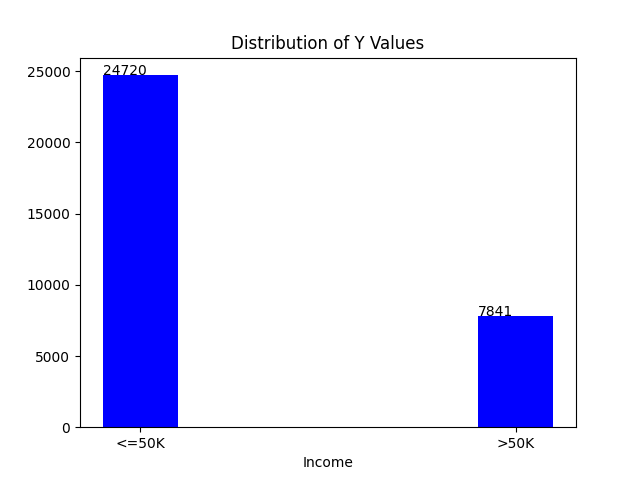

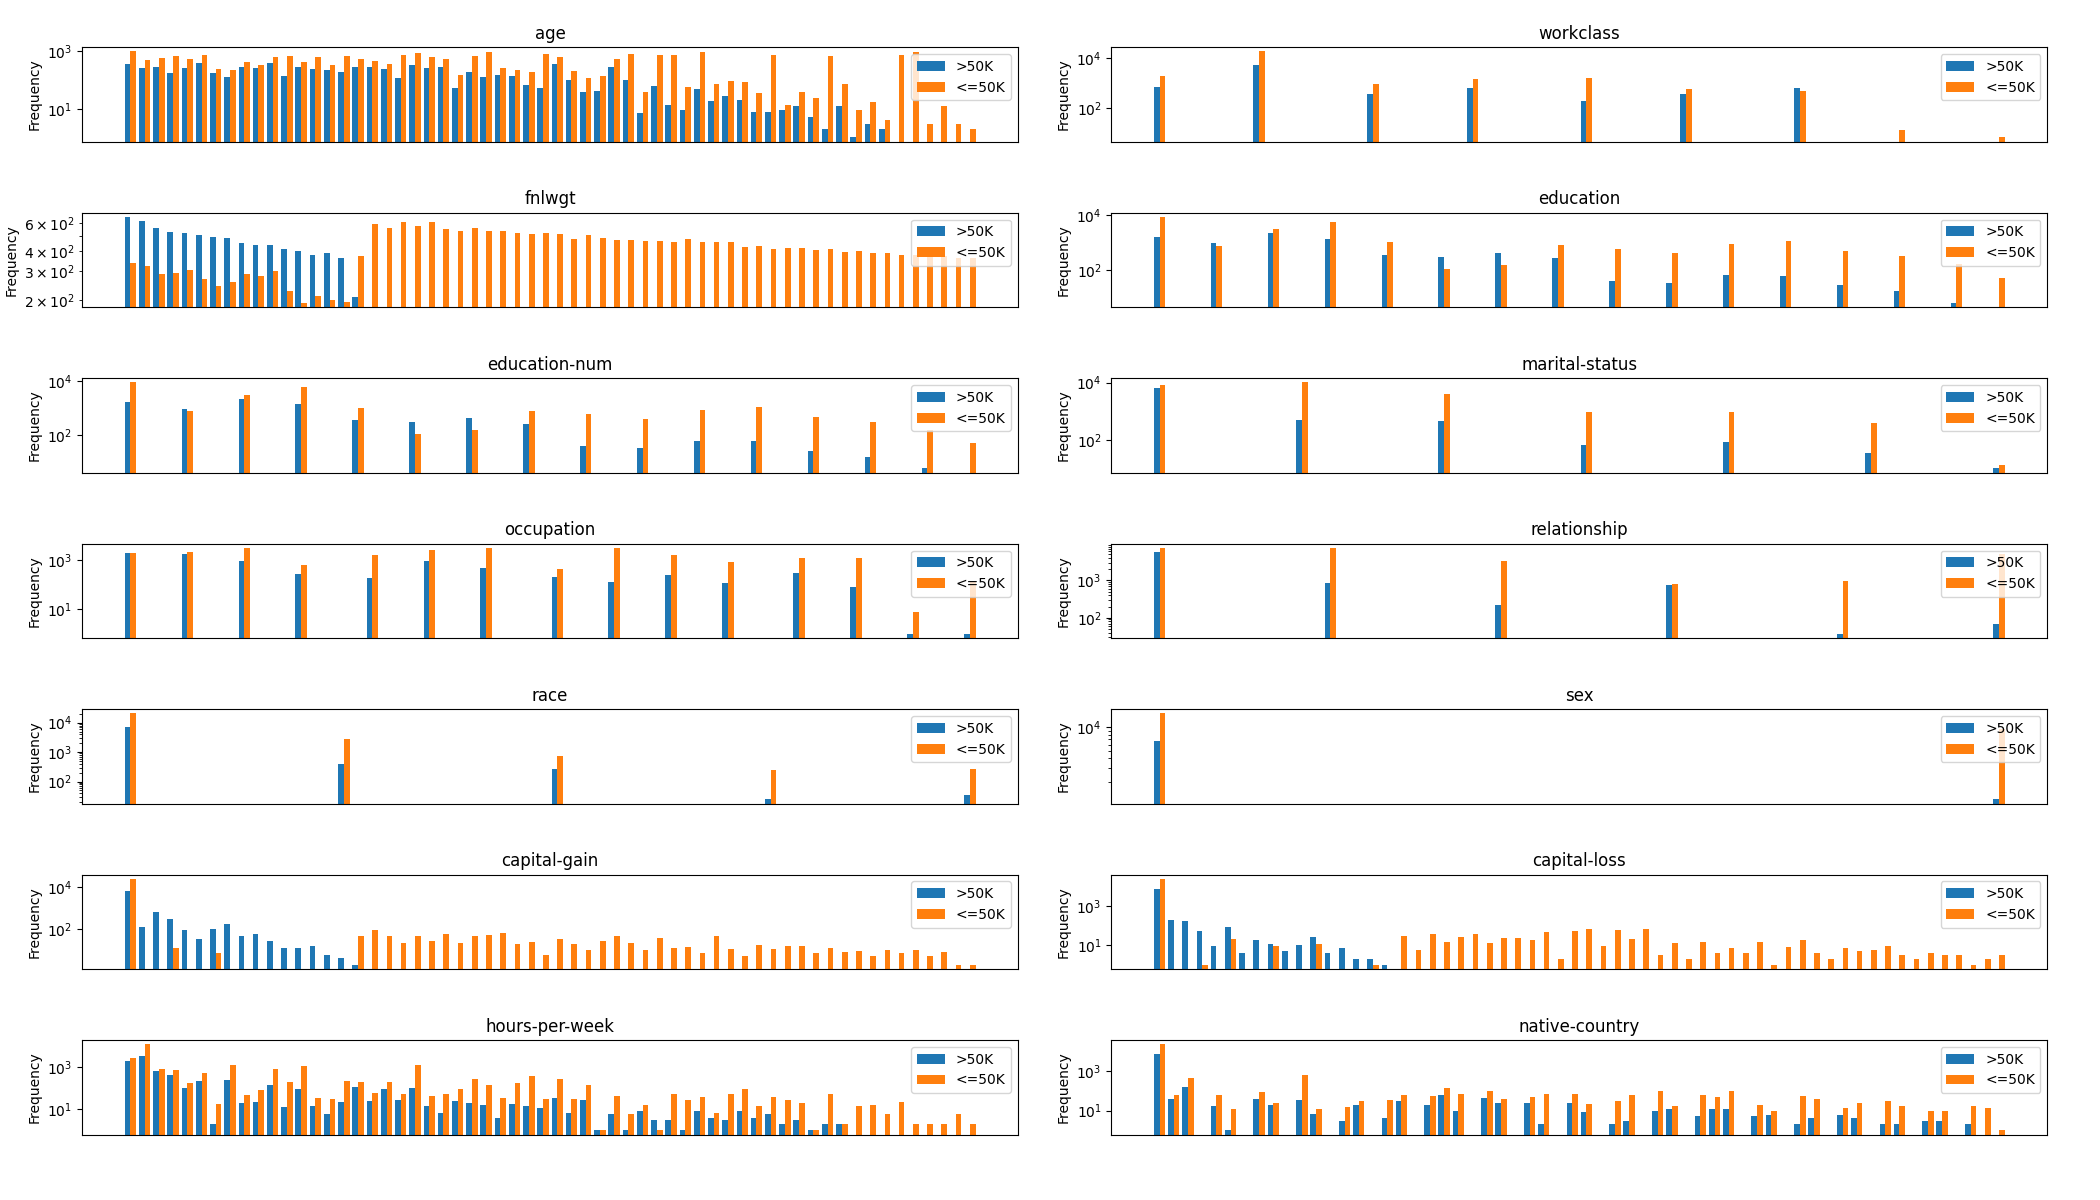

In [20]:
# Visualize data
data = np.loadtxt(open("adult.csv", "r"),dtype='str', delimiter=", ") # I changed the file extension from .data to .csv to use jupyterlab-spreadsheet-editor
visualizeY(data)
visualizeX(data)

In [114]:
# Evaluate model performance
dt = Classifier()

X,Y = dt.getData("adult.csv")
error, f1 = dt.evaluate(X,Y,10)
print("Error:", error," F1 score:", f1)

Error: 0.1843003427129924  F1 score: 0.8815635386776242


In [116]:
# Export trained model
# Fit with 100% of the data to maximize model performance for future predictions
import pickle as p

dtFull = Classifier()
X,Y = dt.getData("adult.csv")
dtFull.fit(X,Y)

p.dump(dtFull, open('models/trained_model.pickle', 'wb'))